<a href="https://colab.research.google.com/github/Motunrayo244/EDISS-MP/blob/main/Data%20Science%20/Project_work/Project3/Mini_Project3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



## Interrelationship of Journals from Various ASJC Domains

---
Academic papers have surpassed 64 million since 1996[1]. Critically organized academic papers present facts and logic on a specific topic. These documentations allow scientists and researchers to share their processes and evaluate or learn from their research. A paper's references are important because they identify previous publications that influenced its research. They link the current study to the global research publication network. [2]

Citation analysis helps explain how research in different fields, authors, or articles are related. Library and information science uses citation analysis to understand the impact of articles, authors, knowledge flow, idea diffusion, intellectual structures of science, and information resource relevance. [2]

The relationships between MIT research domains are examined in this report (MIT). Artifacts published and cited in those domains were analyzed for citations. This project aims to determine which domains have influenced others most.

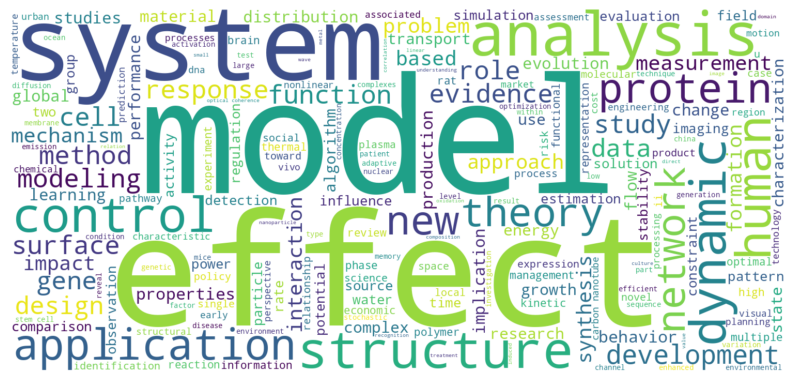

In [1]:
%%capture
!pip install factor-analyzer

In [2]:
import requests, zipfile, io, csv
import numpy as np
import pandas as pd
import networkx as nx
import sys
import random
import math

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity, cosine_distances
from factor_analyzer import FactorAnalyzer
from wordcloud import WordCloud, ImageColorGenerator
from PIL import Image
from networkx import edge_betweenness_centrality as betweenness


import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string

nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

### Download and Extract data
This section downloads the data from https://lens-public.s3-us-west-2.amazonaws.com/sloan/scholarly/201932/mit_scholarly.zip and extracts it to the colab content path.

In [3]:
url = 'https://lens-public.s3-us-west-2.amazonaws.com/sloan/scholarly/201932/mit_scholarly.zip'
r = requests.get(url)
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall('rawdata')

In [4]:
''' This cell inclueds all the functions used to extract features of the publication from the json files'''

def get_nodes(paper_id:str, citations, references):
    ''' This functio writes the citing paper lens_id and the cited paper's lens _id into a csv file'''
    if len(citations)>=1:
        for citation in citations:
            csv_writer.writerow([citation, paper_id])
    #     #     # edge_list.loc[len(edge_list.index)]=[citation, paper_id]
    if len(references)>=1:
        for reference in references:
          csv_writer.writerow([paper_id, reference['lens_id']])
    # #         # edge_list.loc[len(edge_list.index)]= [paper_id, reference['lens_id']]
    return None

def get_country(source_att): # gets the country the paper was published
    try:
        if source_att['country']:
            return source_att['country']
    except Exception:
        return ''
def get_publisher(source_att): # gets the name of the publisher
    try:
        if source_att['publisher']:
            return source_att['publisher']
    except Exception:
        return ''

def decode_asjc_super_group(asjc_code): # Interpretes the ASJC code to get the super fields of the paper.
# Click https://www.journalsindexed.com/2016/06/asjc-code-list.html for more information about ASJC

  if asjc_code in ['27','29','34','35','36']:
    return "Health Sciences"
  elif asjc_code in ['11','13','24','28','30']:
    return 'Life Sciences'
  elif asjc_code in ['15','16','17','19','21','22','23','25','26','31']:
    return 'Physical Sciences'
  elif asjc_code in ['12','14','18','20','32','33']:
    return 'Social Sciences'
  elif asjc_code =='10':
    return "Multidisciplinary"
  else:
    return 'Not Defined'

def decode_asjc_sub_group(asjc_code): # Decodes the asjc code into domains.
  # checke the dictionary for the description of the asjc code

  group_desc = {'10':'Multidisciplinary','11':'Agricultural and Biological Sciences','12':'Arts and Humanities',
                '13':'Biochemistry, Genetics and Molecular Biology','14':'Business, Management and Accounting','15':'Chemical Engineering',
                '16':'Chemistry','17':'Computer Science','18':'Decision Sciences','19':'Earth and Planetary Sciences',
                '20':'Economics, Econometrics and Finance','21':'Energy','22':'Engineering','23':'Environmental Science','24':'Immunology and Microbiology',
                '25':'Materials Science','26':'Mathematics','27':'Medicine','28':'Neuroscience','29':'Nursing',
                '30':'Pharmacology, Toxicology and Pharmaceutics','31':'Physics and Astronomy','32':'Psychology','33':'Social Sciences','34':'Veterinary',
                '35':'Dentistry','36':'Health Professions'}

  return group_desc[asjc_code]


def get_asjc_super_group(source_att):
    try:
        if source_att['asjc_codes']:
            code_grp_list = (list(set([x[:2] for x in source_att['asjc_codes']])))
           # get the super group
            super_grp_list = [decode_asjc_super_group(x) for x in code_grp_list]
            return (list(set(super_grp_list)))

    except Exception:
        return ''

def get_asjc_sub_group(source_att):
    try:
        if source_att['asjc_codes']:
            code_grp_list = (list(set([x[:2] for x in source_att['asjc_codes']])))
           # get the super group
            sub_grp_list = [decode_asjc_sub_group(x) for x in code_grp_list]

            return (list(set(sub_grp_list)))
    except Exception:
        return ''


def get_affiliations (authors_att): # returns a list of all the affilliation of the paper or article
  try:
    if authors_att:

      affiliations=[]
      for author in authors_att:
        affils =  author['affiliations']
        for affil in affils:

          affiliations.append(affil['name'])

      return (list(set(affiliations)))

  except Exception:
    return ''

def get_affiliations_country(authors_att):
  affiliations_country=[]
  try:
    if authors_att:

      for author in authors_att:
        affils =  author['affiliations']
        affiliations_country.extend(affil['country_code'] for affil in affils)
      return (list(set(affiliations_country)))

  except Exception as e:
    return (list(set(affiliations_country)))


def get_source_attrib(dict_,source_att):
    try:
        if dict_[source_att]:
            return dict_[source_att]
    except Exception:
        return ''


In [5]:
#This cell creates the csv file for the source and target list (i.e citer paper and cited paper)
csv_file = open('edge_list.csv','w', encoding='utf-8')
csv_writer = csv.writer(csv_file)
csv_writer.writerow(['Source', 'Target' ])

15

In [6]:
# Creates a dataframe that contains all the infomation about the published work that is to be extracted.
edge_info = pd.DataFrame(columns=['lens_id','publication_type','open_access','title','references_count','pub_country',
                                  'publisher','author_count','year_published','scholarly_citations_count','patent_citations_count', 'asjc_super_group','asjc_sub_group', 'authors_affiliations','authors_affiliations_countries'])

In [7]:
# Loops thrugh the 20 json file that was downloaded and extract the citing information as well as the paper information,.
for i in range(20):
  filename = f'export-{i}.jsonl'
  df = pd.read_json(f"rawdata/{filename}", lines=True)
  df.fillna('',inplace=True)

  df.apply(lambda x: get_nodes(x['lens_id'],x['scholarly_citations'],x['references']),axis=1)
  new_df = pd.DataFrame()
  new_df['lens_id'] = df['lens_id']
  new_df['publication_type'] = df['publication_type']
  new_df['open_access'] = df['open_access']
  new_df['title'] = df['title']
  new_df['references_count'] = df['references_count']
  new_df['pub_country'] = df['source'].apply(lambda x: get_country(x))
  new_df['publisher'] = df['source'].apply(lambda x: get_publisher(x))
  new_df['author_count'] = df['author_count']
  new_df['year_published'] =df['year_published']
  # new_df['year_published'] = df['date_published'].apply(lambda x: str(x).split('-')[0] if str(x)!= 'nan' else '')
  new_df['scholarly_citations_count']= df['scholarly_citations_count']
  new_df['patent_citations_count']= df['patent_citations_count']
  new_df['asjc_super_group'] = df['source'].apply(lambda x: get_asjc_super_group(x))
  new_df['asjc_sub_group'] = df['source'].apply(lambda x: get_asjc_sub_group(x))
  new_df['authors_affiliations'] = df['authors'].apply(lambda x: get_affiliations(x))
  new_df['authors_affiliations_countries'] = df['authors'].apply(lambda x: get_affiliations_country(x))
  edge_info = pd.concat([edge_info,new_df], ignore_index = True)

   # edge_info.to_csv('edge_info.csv', sep=',', index=False,header=True)
print(f'Reading JSON completed ..............')
csv_file.close()
edge_info.to_csv('edge_info.csv', sep=',', index=False,header=True)
edge_info = None


Reading JSON completed ..............


### Load and Preprocess Data

This sections loads the data from the csv file and preprocesses it

In [8]:
citation_data = pd.read_csv("edge_list.csv")


In [9]:
citation_data.shape

(15347188, 2)

In [10]:
citation_info = pd.read_csv("edge_info.csv")

In [11]:
citation_info.drop_duplicates(subset=['lens_id'], inplace=True)

In [12]:
print(f" the number of articles are: {citation_info.shape[0] }")
print(f" the number of articles without asjc groups are: {citation_info['asjc_super_group'].isna().sum()}")
print(f" the number of articles with asjc groups are: {citation_info.shape[0] - citation_info['asjc_super_group'].isna().sum()}")

 the number of articles are: 194506
 the number of articles without asjc groups are: 86188
 the number of articles with asjc groups are: 108318


In [13]:
citation_info = citation_info.fillna('')

In [14]:
citation_info.loc[citation_info["scholarly_citations_count"] == "", "scholarly_citations_count"] = 0
citation_info.loc[citation_info["patent_citations_count"] == "", "patent_citations_count"] = 0

citation_info.loc[citation_info["author_count"] == "", "author_count"] = 0

citation_info.loc[citation_info["publication_type"] == "conference proceedings article", "publication_type"]= 'conference proceedings'

In [15]:
# group the year the work was publised
def get_year_group(year)-> int:
  if int(year) < 1966:
    return 1
  elif int(year) < 1980:
    return 2
  elif int(year) < 1995:
    return 3
  elif int(year) < 2010:
    return 4
  else:
    return 5
# specify if the domain is computer science alone
def is_compsci_alone(asjc_groups)->bool:
  asjc_list = asjc_groups.replace("[",'').replace("']",'').replace("'",'').split(',')
  if len(asjc_list) == 1 and asjc_list[0] =='Computer Science':
    return 0
  else:
    return 1

In [16]:
# cd_comp.head(5)

In [17]:
citation_info['main_super_group'] = citation_info['asjc_super_group'].apply(lambda x: x.split(",")[0].replace("[",'').replace("']",'').replace("'",''))
citation_info['main_sub_group'] = citation_info['asjc_sub_group'].apply(lambda x: x.split(",")[0].replace("[",'').replace("']",'').replace("'",''))
citation_info['year_group'] = citation_info['year_published'].apply(get_year_group)
citation_info['is_comp_only'] = citation_info['asjc_sub_group'].apply(is_compsci_alone)


In [18]:
citation_info["publication_type"].unique()

array(['journal article', 'book chapter', 'conference proceedings',
       'book', 'report', '', 'other', 'dataset', 'component',
       'reference entry', 'dissertation', 'editorial'], dtype=object)

In [19]:
# citation_info= citation_info [citation_info ['scholarly_citations_count'].apply(lambda x: x >= 5)]

In [20]:
citation_info.shape

(194506, 19)

In [21]:
citation_info = citation_info[citation_info['main_sub_group']!= '']

In [22]:
citation_info.shape

(108318, 19)

### Exploratory Data Analysis

This section carries out EDA on the node attributes.

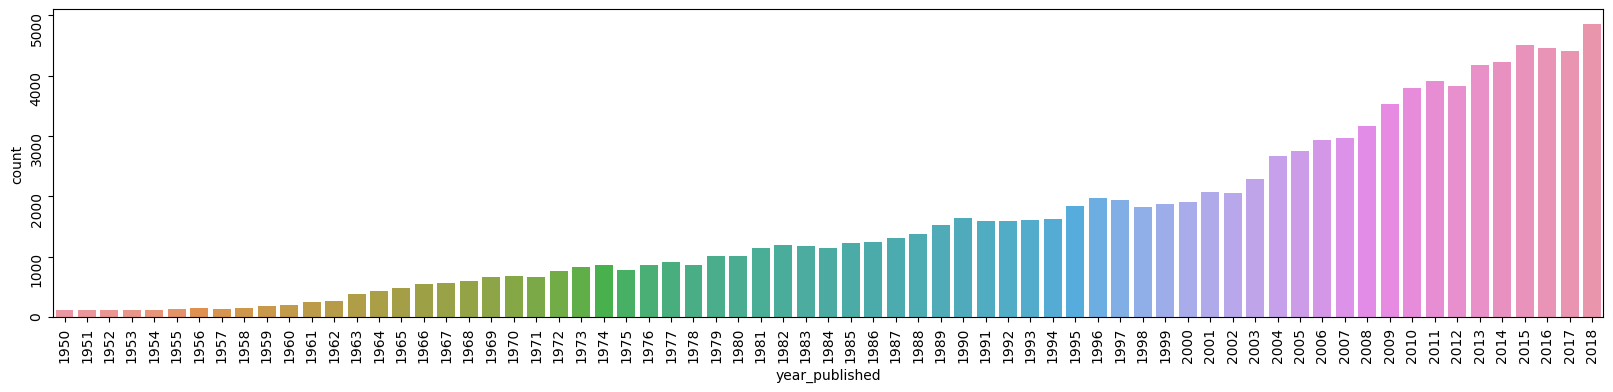

In [23]:
fig, ax = plt.subplots(figsize=(20, 4))
sns.countplot(data=citation_info, x='year_published' )
ax.tick_params(rotation=90)

plt.show()

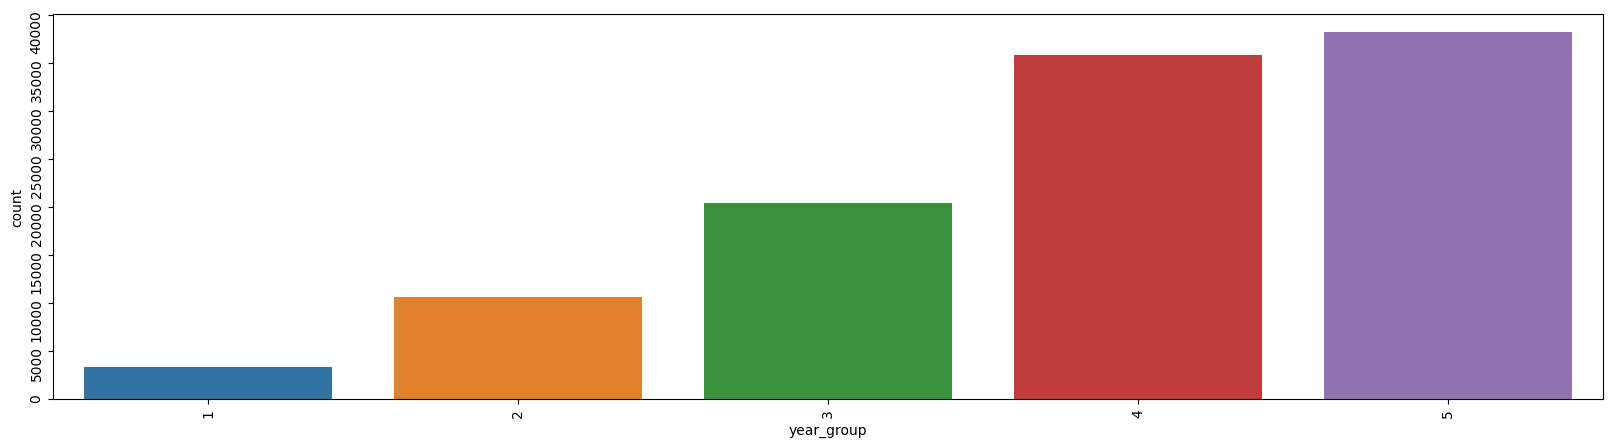

In [24]:
fig, ax = plt.subplots(figsize=(20, 5))
sns.countplot(data=citation_info, x='year_group' )
ax.tick_params(rotation=90)

plt.show()

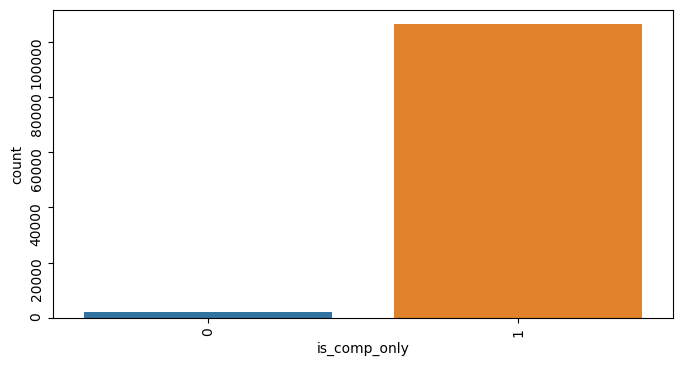

In [25]:
fig, ax = plt.subplots(figsize=(8, 4))
sns.countplot(data=citation_info, x='is_comp_only' )
ax.tick_params(rotation=90)

plt.show()

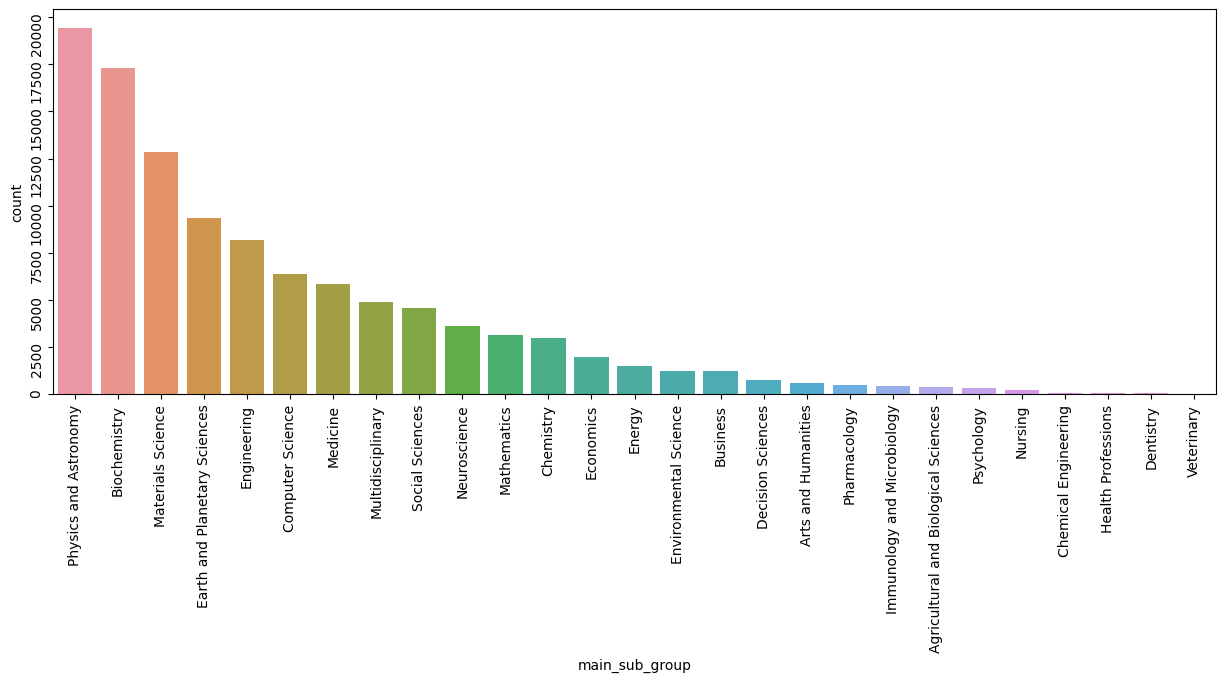

In [26]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.countplot(data=citation_info, x='main_sub_group', order=citation_info['main_sub_group'].value_counts().index )
ax.tick_params(rotation=90)

plt.show()

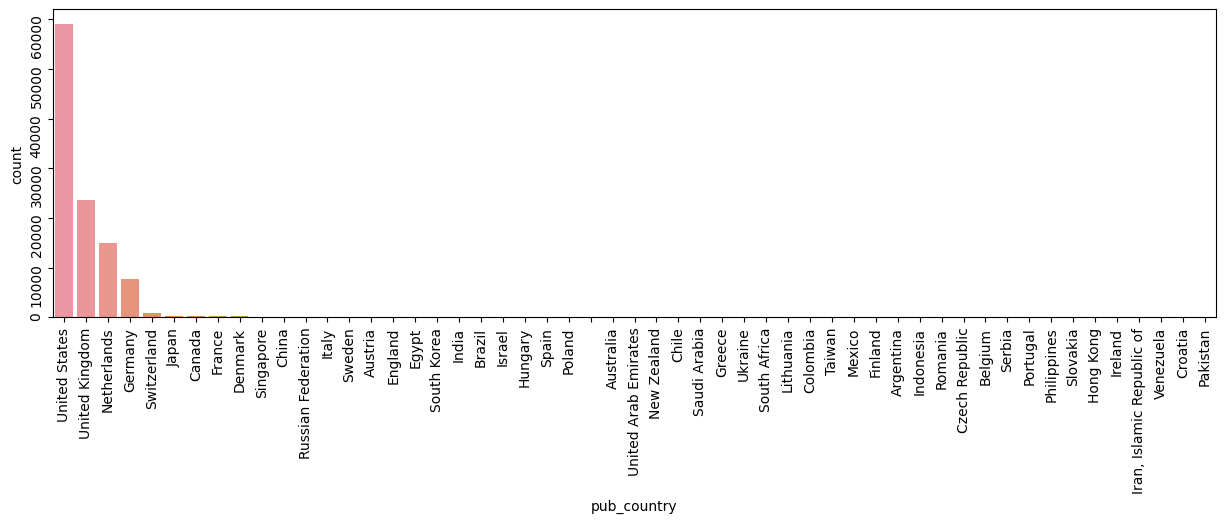

In [27]:
fig, ax = plt.subplots(figsize=(15, 4))
sns.countplot(data=citation_info, x='pub_country', order=citation_info['pub_country'].value_counts().index )
ax.tick_params(rotation=90)

plt.show()

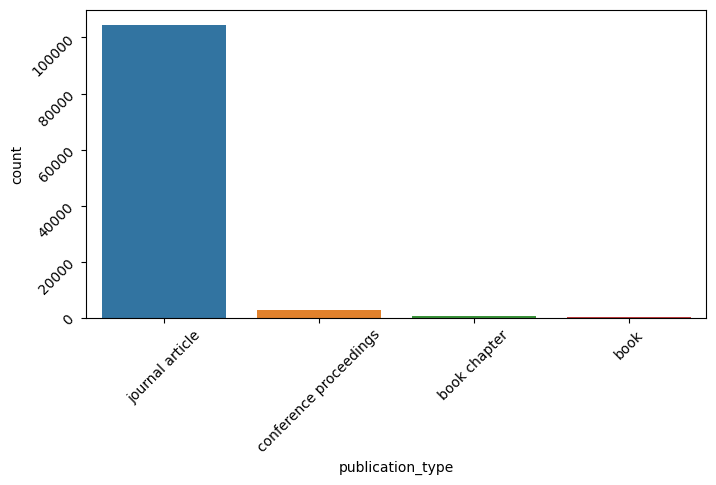

In [28]:
fig, ax = plt.subplots(figsize=(8, 4))
sns.countplot(data=citation_info, x='publication_type', order=citation_info['publication_type'].value_counts().index )
ax.tick_params(rotation=45)

plt.show()

In [29]:
def preprocess_text(text):
  custom_stopwords = ['using', 'via']
  stop_words = set(stopwords.words('english'))
  stop_words.update(custom_stopwords)

  text = text.lower()
  text = text.translate(str.maketrans('', '', string.punctuation))  # Remove punctuation
  words = word_tokenize(text)
  words = [word for word in words if word not in stop_words]  # Remove stopwords
  return " ".join(words)

In [ ]:
text_df = pd.DataFrame()
text_df['title'] =citation_info['title'].apply(preprocess_text)
# text_df['authors_affiliations']= cd_comp_pb['authors_affiliations'].apply(preprocess_text)
text_df['authors_affiliations'] =citation_info['authors_affiliations'].apply(lambda x: x.replace('[','').replace(']','').replace("'",'').replace(",",' ').replace("Massachusetts Institute of Technology",''))
text_df['authors_affiliations_countries'] =citation_info['authors_affiliations_countries'].apply(lambda x: x.replace('[','').replace(']','').replace("'",'').replace(",",' ').upper()).apply(preprocess_text)
text_df['asjc_sub_group'] = citation_info['asjc_sub_group'].apply(lambda x: x.replace('[','').replace(']','').replace("'",'').replace("Science",'')).apply(preprocess_text)

In [ ]:

text = " ".join(text_df['title'])

# Create a WordCloud object
wordcloud = WordCloud(width=1500, height=700, background_color='white').generate(text)

# Display the word cloud using matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()


In [ ]:
text = " ".join(text_df['authors_affiliations'])

# Create a WordCloud object
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

# Display the word cloud using matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()


In [ ]:
text = " ".join(text_df['authors_affiliations_countries'])

# Create a WordCloud object
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

# Display the word cloud using matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()


In [ ]:
text = " ".join(text_df['asjc_sub_group'])

# Create a WordCloud object
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

# Display the word cloud using matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [ ]:
ax = sns.displot(data=citation_info, x='references_count',bins=25,aspect=2,legend=True )
ax.tick_params(rotation=90)
plt.show()

In [ ]:
ax = sns.displot(data=citation_info, x='scholarly_citations_count',bins=1000,aspect=3,legend=True )
ax.tick_params(rotation=90)
plt.show()

In [ ]:
max_row = citation_info[citation_info['scholarly_citations_count'] == citation_info['scholarly_citations_count'].max()]

In [ ]:
max_row

In [ ]:
less_max_row = citation_info[citation_info['scholarly_citations_count'] <=500]

In [ ]:
ax = sns.displot(data=less_max_row, x='scholarly_citations_count',bins=20,aspect=2,legend=True, hue='year_group', palette = 'dark' )
ax.tick_params(rotation=90)
plt.show()

In [ ]:
ax = sns.displot(data=citation_info, x='author_count',bins=25,aspect=2,legend=True )
ax.tick_params(rotation=90)
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(8,8))

citation_info['publisher'].value_counts().plot(kind="pie", autopct="%.1f", labeldistance=1.1)

plt.show()


In [ ]:
df_sorted = df.sort_values(by='scholarly_citations_count', ascending=False).groupby('Discipline').head(5000)


In [ ]:
citation_info_old = citation_info

In [ ]:
citation_info_n= citation_info.sort_values(by='scholarly_citations_count', ascending=False).groupby('main_sub_group').head(2000)

In [ ]:
citation_info_n.shape

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.countplot(data=citation_info_n, x='main_sub_group', order=citation_info['main_sub_group'].value_counts().index )
ax.tick_params(rotation=90)

plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(20, 5))
sns.countplot(data=citation_info_n, x='year_group' )
ax.tick_params(rotation=90)

plt.show()

In [ ]:
def get_target_word(title):
    target_words = ['machine learning', 'deep learning','intelligent systems' ,'neural network', 'communication network', 'system network','network', 'data collection', 'optimization problem'
                    'human computer','robot','algorithm', 'prediction', 'gene', 'prediction', 'optimization', 'model']

    # Convert the title to lowercase for case-insensitive matching
    lower_title = title.lower()

    # Use any with a generator expression to check if any target word is in the title
    if any(word in lower_title for word in target_words):
        for word in target_words:
            if word in lower_title:
                return word


In [ ]:
# List of target words to check for in the title

# Create a new column based on the presence of any target word in the title
citation_info_n['target_Word'] = citation_info_n['title'].apply(get_target_word)


In [ ]:
citation_info_n['target_Word'].unique() #shape

In [ ]:
fig, ax = plt.subplots(figsize=(20, 5))
sns.countplot(data=citation_info_n, x='target_Word' )
ax.tick_params(rotation=90)

plt.show()

In [ ]:
citation_info = citation_info_n

### Citation Analysis using Networkx

In [ ]:
lens_id  = citation_info['lens_id'].tolist()

In [ ]:
len(lens_id)

In [ ]:
node_list = citation_data[citation_data['Source'].isin(lens_id)]

In [ ]:
node_list.shape

In [ ]:
node_list = node_list[node_list['Target'].isin(lens_id)]

In [ ]:
node_list.shape

In [ ]:
node_list = node_list.reset_index(drop=True)

In [ ]:
G_ = nx.from_pandas_edgelist(node_list, "Source", "Target", create_using=nx.DiGraph())

In [ ]:
G_.number_of_nodes()

In [ ]:
G_.number_of_edges()

In [ ]:
node_info = citation_info.set_index('lens_id').to_dict('index')

In [ ]:
nx.set_node_attributes(G_,node_info)

In [ ]:
G_.remove_nodes_from(list(nx.isolates(G_)))

In [ ]:
self_loop = list(nx.selfloop_edges(G_))

In [ ]:
self_loop = list(nx.selfloop_edges(G_))
len(self_loop)

In [ ]:
self_loop[:5]

In [ ]:
for e in self_loop:
  G_.remove_edge(*e)

In [ ]:
citation_info['year_group'].unique()

In [ ]:
sub_group = citation_info['main_sub_group'].unique()
colors = ["yellow", "orange", "brown", "green", "blue", "purple", "cyan", "magenta", "red", "pink", "teal", "lime", "olive", "navy", "maroon", "turquoise", "indigo",
          "violet", "lightcoral", "darkgreen", "skyblue", "darkorange", "mediumseagreen", "mediumslateblue", "coral", "mediumaquamarine", 'gold']

sub_group_cc = dict(zip(sub_group,colors))
sub_group_cm = [sub_group_cc[data['main_sub_group']] for node, data in G_.nodes(data=True)]


In [ ]:
sup_group = citation_info['main_super_group'].unique()
colors = ["yellow", "orange", "brown", "green", "blue", "purple", "cyan", "magenta", "red", "pink", "teal", "lime", "olive", "navy", "maroon", "turquoise", "indigo",
          "violet", "lightcoral", "darkgreen", "skyblue", "darkorange", "mediumseagreen", "mediumslateblue", "coral", "mediumaquamarine", 'gold']

sup_group_cc = dict(zip(sup_group,colors))

In [ ]:
sub_group = citation_info['target_Word'].unique()
colors = ["yellow", "orange", "brown", "green", "blue", "purple", "cyan", "magenta", "red", "pink", "teal",  "maroon", "turquoise", "indigo",
          "violet", "lightcoral", "darkgreen", "skyblue",  'gold']

tg_word_cc = dict(zip(sub_group,colors))
tg_word_cm = [tg_word_cc[data['target_Word']] for node, data in G_.nodes(data=True)]

In [ ]:
pos = nx.spring_layout(G_, iterations=10, seed=1200)

In [ ]:
fig, ax = plt.subplots(figsize=(20, 8))
ax.axis("off")
plot_options = {"node_size": 40, "node_color":tg_word_cm}

nx.draw_networkx_nodes(G_, pos=pos, ax=ax, **plot_options)

In [ ]:
year_group = set(nx.get_node_attributes(G_, 'year_group').values())

for year in year_group:
    subgraph_nodes = [node for node, attrs in G_.nodes(data=True) if attrs['year_group'] == year]
    subgraph = G_.subgraph(subgraph_nodes)
    sup_group_cm = [sup_group_cc[data['main_super_group']] for node, data in subgraph.nodes(data=True)]

    fig, ax = plt.subplots(figsize=(20, 5))
    ax.axis("off")
    plot_options = {"node_size": 40, "node_color":sup_group_cm}
    pos = nx.spring_layout(subgraph)
    nx.draw_networkx(subgraph, pos=pos, ax=ax, with_labels=False, **plot_options)

In [ ]:
asjc_G = nx.DiGraph()
for edge in G_.edges():
    source_node, target_node = edge
    source_group = G_.nodes[source_node]['main_sub_group']
    target_group = G_.nodes[target_node]['main_sub_group']

    # Add or update the weight of the directed edge
    if asjc_G.has_edge(source_group, target_group):
        asjc_G[source_group][target_group]['weight'] += 1
    else:
        asjc_G.add_edge(source_group, target_group, weight=1)


In [ ]:
# remove the self loop in te citation matrix
self_loop = list(nx.selfloop_edges(asjc_G))
for e in self_loop:
  asjc_G.remove_edge(*e)

In [ ]:
pos = nx.circular_layout(asjc_G) #, iterations=3,weight='weight')
fig, ax = plt.subplots(figsize=(25, 8))
ax.axis("off")
plot_options = {"node_size": 100, "with_labels": True, "width": 0.5, "node_color":'blue'}

nx.draw(asjc_G, pos, with_labels=True, node_size=200, node_color='red',alpha=0.9, font_size=10, font_color='black', edge_color='green', width=[0.2 * math.log(asjc_G[u][v]['weight']) for u, v in asjc_G.edges()],
        labels={node: node for node in asjc_G.nodes()})

# nx.draw_networkx_edge_labels(asjc_G, pos,{(u, v): asjc_G[u][v]['weight'] for u, v in asjc_G.edges()}, font_color='red')
plt.title("Subgraph Focusing on Nodes ")
plt.axis('off')
plt.show()




In [ ]:
# Create a subgraph by specifying a list of nodes
nodes_to_include = ['Computer Science', 'Economics', 'Business', 'Social Sciences', 'Arts and Humanities', 'Multidisciplinary','Decision Sciences','Psychology']
subgraph = asjc_G.subgraph(nodes_to_include)

fig, ax = plt.subplots(figsize=(20, 6))
# Create a plot for the subgraph
# pos_subgraph = nx.spring_layout(subgraph, iterations=1, seed=30)
pos_subgraph = nx.circular_layout(subgraph)
nx.draw(subgraph, pos_subgraph, with_labels=True, node_size=200, node_color='red',alpha=0.9, font_size=10, font_color='black', edge_color='green', width=[0.2 * math.log(subgraph[u][v]['weight']) for u, v in subgraph.edges()],
        labels={node: node for node in subgraph.nodes()})

edge_labels = {(u, v): subgraph[u][v]['weight'] for u, v in subgraph.edges()}
nx.draw_networkx_edge_labels(subgraph, pos_subgraph,{(u, v): subgraph[u][v]['weight'] for u, v in subgraph.edges()}, font_color='red')
plt.title("Subgraph Focusing on Nodes Social Science and Computer Science")
plt.axis('off')
plt.show()

In [ ]:
nodes_to_include = ['Computer Science', 'Physics and Astronomy', 'Earth and Planetary Sciences', 'Materials Science', 'Environmental Science',
                    'Energy', 'Multidisciplinary','Engineering','Mathematics','Chemistry','Chemical Engineering']
subgraph = asjc_G.subgraph(nodes_to_include)

fig, ax = plt.subplots(figsize=(20, 6))
# Create a plot for the subgraph
# pos_subgraph = nx.spring_layout(subgraph, iterations=1, seed=550)
pos_subgraph = nx.circular_layout(subgraph)
nx.draw(subgraph, pos_subgraph, with_labels=True, node_size=200, node_color='red',alpha=0.9, font_size=10, font_color='black', edge_color='green', width=[0.3 * math.log(subgraph[u][v]['weight']) for u, v in subgraph.edges()],
        labels={node: node for node in subgraph.nodes()})

edge_labels = {(u, v): subgraph[u][v]['weight'] for u, v in subgraph.edges()}
# nx.draw_networkx_edge_labels(subgraph, pos_subgraph,{(u, v): subgraph[u][v]['weight'] for u, v in subgraph.edges()}, font_color='red')
plt.title("Subgraph Focusing on Nodes Physical Sciences ")
plt.axis('off')
plt.show()

In [ ]:
nodes_to_include = [ 'Computer Science','Immunology and Microbiology', 'Neuroscience', 'Pharmacology',  'Multidisciplinary','Agricultural and Biological Sciences','Biochemistry']
subgraph = asjc_G.subgraph(nodes_to_include)

fig, ax = plt.subplots(figsize=(20, 6))
# Create a plot for the subgraph
# pos_subgraph = nx.spring_layout(subgraph, iterations=1, seed=550)
pos_subgraph = nx.circular_layout(subgraph)
nx.draw(subgraph, pos_subgraph, with_labels=True, node_size=200, node_color='red',alpha=0.7, font_size=10, font_color='black', edge_color='green', width=[0.2 * math.log(subgraph[u][v]['weight']) for u, v in subgraph.edges()],
        labels={node: node for node in subgraph.nodes()})

edge_labels = {(u, v): subgraph[u][v]['weight'] for u, v in subgraph.edges()}
nx.draw_networkx_edge_labels(subgraph, pos_subgraph,{(u, v): subgraph[u][v]['weight'] for u, v in subgraph.edges()}, font_color='red')
plt.title("Subgraph Focusing on Nodes Life Sciences ")
plt.axis('off')
plt.show()

In [ ]:
nodes_to_include = [ 'Computer Science','Medicine', 'Nursing', 'Veterinary',  'Multidisciplinary','Health Professions', 'Dentistry']
subgraph = asjc_G.subgraph(nodes_to_include)

fig, ax = plt.subplots(figsize=(20, 6))
# Create a plot for the subgraph
# pos_subgraph = nx.spring_layout(subgraph, iterations=1, seed=550)
pos_subgraph = nx.circular_layout(subgraph)
nx.draw(subgraph, pos_subgraph, with_labels=True, node_size=200, node_color='red',alpha=0.7, font_size=10, font_color='black', edge_color='green', width=[0.3 * math.log(subgraph[u][v]['weight']) for u, v in subgraph.edges()],
        labels={node: node for node in subgraph.nodes()})

edge_labels = {(u, v): subgraph[u][v]['weight'] for u, v in subgraph.edges()}
nx.draw_networkx_edge_labels(subgraph, pos_subgraph,{(u, v): subgraph[u][v]['weight'] for u, v in subgraph.edges()}, font_color='red')
plt.title("Subgraph Focusing on Nodes ")
plt.axis('off')
plt.show()

In [ ]:
nodes_to_include = [ 'Computer Science', 'Veterinary',  'Pharmacology', 'Dentistry']
subgraph = asjc_G.subgraph(nodes_to_include)

fig, ax = plt.subplots(figsize=(20, 6))
# Create a plot for the subgraph
# pos_subgraph = nx.spring_layout(subgraph, iterations=1, seed=550)
pos_subgraph = nx.circular_layout(subgraph)
nx.draw(subgraph, pos_subgraph, with_labels=True, node_size=200, node_color='red',alpha=0.7, font_size=10, font_color='black', edge_color='green', width=[1 * math.log(subgraph[u][v]['weight']) for u, v in subgraph.edges()],
        labels={node: node for node in subgraph.nodes()})

edge_labels = {(u, v): subgraph[u][v]['weight'] for u, v in subgraph.edges()}
nx.draw_networkx_edge_labels(subgraph, pos_subgraph,{(u, v): subgraph[u][v]['weight'] for u, v in subgraph.edges()}, font_color='red')
plt.title("Subgraph Focusing on Nodes ")
plt.axis('off')
plt.show()

In [ ]:
asjc_G.number_of_nodes()

In [ ]:
asjc_G.number_of_edges()

In [ ]:
nx.density(G)

In [ ]:
triadic_closure = nx.transitivity(G)
print(f" Traidic closure: {triadic_closure}")

In [ ]:
comp = nx.community.girvan_newman(asjc_G, most_valuable_edge=None)

c = tuple(sorted(tuple(sorted(community)) for community in next(comp)))

# Sort the communities based on the size of each community
sorted_comm = sorted(c, key=len, reverse=True)



In [ ]:
len(sorted_comm)

In [ ]:
G = asjc_G

In [ ]:
# Create a dictionary to map nodes to their respective community index
community_assignments = {node: i for i, community in enumerate(sorted_comm) for node in community}


# Draw the graph using a spring layout (you may want to try different layouts depending on your data)
pos = nx.spring_layout(G, iterations=1,seed=10,k=5)

In [ ]:
# Calculate community strengths (you may replace this with a relevant metric)
community_strengths = {i: len(community) for i, community in enumerate(sorted_comm)}

# Sort communities by strength and get the top 20
top_communities = sorted(community_strengths.keys(), key=lambda x: community_strengths[x], reverse=True)[:10]


# Draw only nodes from the top 20 communities
subset_nodes = [node for node, community in community_assignments.items() if community in top_communities]

# Assign colors based on communities
colors = [community_assignments[node] for node in subset_nodes]

# Draw the graph using a spring layout (you may want to try different layouts depending on your data)


# Draw the subset of nodes
fig, ax = plt.subplots(figsize=(20, 5))
ax.axis("off")
nx.draw(G.subgraph(subset_nodes), pos, node_color=colors, cmap=plt.cm.viridis, with_labels=True, node_size=30)
# nx.draw(G, pos, node_color='lightblue', with_labels=False, font_weight='bold', node_size=30)
nx.draw_networkx_nodes(G, pos, nodelist=sorted_comm[0], node_color='salmon')
nx.draw_networkx_nodes(G, pos, nodelist=sorted_comm[1], node_color='skyblue')
# nx.draw_networkx_nodes(G, pos, nodelist=sorted_comm[2], node_color='red')
# Display the plot
plt.show()


In [ ]:
#  Create a colormap to assign a unique color to each cluster
colors = plt.cm.get_cmap('tab20', len(c))

# Create a dictionary to map nodes to their cluster color
node_colors = {}
for i, cluster in enumerate(c):
    for node in cluster:
        node_colors[node] = colors(i)

# Visualize the full graph with nodes colored by their clusters
pos = nx.spring_layout(G)  # Choose an appropriate layout
plt.figure(figsize=(20, 8))
nx.draw(G, pos, node_size=100, node_color=[node_colors[node] for node in G.nodes()], with_labels=True, font_size=8, font_color='black', edge_color='gray')
plt.title("Graph with Nodes Colored by Clusters")
plt.show()

In [ ]:
len(c)

In [ ]:
sorted_c = sorted(c, key=lambda x: len(x), reverse=True)
index_list = range(10)
# Visualize each cluster as a subgraph
for index, cluster_nodes in zip(index_list,sorted_c):
    subgraph = G.subgraph(cluster_nodes)
    pos = nx.spring_layout(subgraph, iterations=10, seed=100)  # Choose an appropriate layout
    # pos = nx.circular_layout(subgraph)# iterations=10, seed=100)  # Choose an appropriate layout
    plt.figure(figsize=(20, 8))
    # sup_color_map = [category_colors[data['main_super_group']] for node, data in subgraph.nodes(data=True)]
    # sub_group_cm = [sub_group_cc[data['main_sub_group']] for node, data in subgraph.nodes(data=True)]
    nx.draw(subgraph, pos, with_labels=True, node_size=50, node_color='green', font_size=8, font_color='black', edge_color='gray')
    plt.title(f"Cluster {index}")
    plt.show()

### Co - citation Analysis
*`This sections contains the analysis of centrality and co-citation analysis.`*

**Co-citation**:Co-citation occurs when two documents receive a citation from the same third document.

**Biblographic coupling Frequency**:   Bibliographic coupling occurs when two studies cite the same third document.


In [ ]:
most_connected_node = max(G.nodes, key=lambda node: G.degree(node))
G.degree(most_connected_node)

In [ ]:
sorted_nodes = sorted(G.nodes, key=lambda node: G.degree(node), reverse=True)
sorted_dict = {node: G.degree(node) for node in sorted_nodes}

# Display the sorted dictionary
print(sorted_dict)

In [ ]:
most_connected_node

In [ ]:
closeness_centrality = nx.closeness_centrality(G)
most_central_node = max(closeness_centrality, key=closeness_centrality.get)
most_central_node

In [ ]:
closeness_centrality = nx.closeness_centrality(G)
sorted_nodes = sorted(G.nodes, key=lambda node: closeness_centrality[node], reverse=True)
sorted_dict = {node: closeness_centrality[node] for node in sorted_nodes}

# Display the sorted dictionary
print(sorted_dict)

In [ ]:
# Betweenness centrality measures the extent to which a node lies on the shortest paths between other nodes.
betweenness_centrality = nx.betweenness_centrality(G)
most_btw_central_node = max(betweenness_centrality, key=betweenness_centrality.get)

most_btw_central_node

In [ ]:
betweenness_centrality = nx.betweenness_centrality(G)
sorted_nodes = sorted(G.nodes, key=lambda node: betweenness_centrality[node], reverse=True)
sorted_dict = {node: betweenness_centrality[node] for node in sorted_nodes}

# Display the sorted dictionary
print(sorted_dict)

In [ ]:
# Eigenvector centrality takes into account the centrality of a node and the centrality of its neighbors.
eigenvector_centrality = nx.eigenvector_centrality(G)
most_eigen_central_node = max(eigenvector_centrality, key=eigenvector_centrality.get)

most_eigen_central_node

In [ ]:
# Extract neighbors of the most connected node
neighbors_mcn = list(G.predecessors(most_connected_node)) + [most_connected_node] + list(G.neighbors(most_connected_node))
neighbors_mbn = list(G.neighbors(most_btw_central_node)) + [most_btw_central_node] + list(G.predecessors(most_btw_central_node))
neighbors_mevn = list(G.neighbors(most_eigen_central_node)) + [most_eigen_central_node] + list(G.predecessors(most_eigen_central_node))
# Create a subgraph with the most connected node and its neighbors
subgraph1 = G.subgraph(neighbors_mcn)
subgraph2 = G.subgraph(neighbors_mbn)
subgraph3 = G.subgraph(neighbors_mevn)

# Draw the subgraph
plt.figure(figsize=(15, 5))
pos = nx.spring_layout(G, iterations=3)
nx.draw(subgraph1, pos, with_labels=True, node_size=50, node_color='blue', font_size=8, edge_color='darkgray')
# nx.draw(subgraph2, pos, with_labels=True, node_size=50, node_color='blue', font_size=8, edge_color='grey')
nx.draw(subgraph3, pos, with_labels=True, node_size=50, node_color='blue', font_size=8, edge_color='gray')


# Highlight the most connected node
# sub_group_cm = [sub_group_cc[data['main_sub_group']] for node, data in subgraph.nodes(data=True)]
nx.draw_networkx_nodes(subgraph1, pos, nodelist=[most_connected_node], node_color='red', node_size=100)
# nx.draw_networkx_nodes(subgraph2, pos, nodelist=[most_btw_central_node], node_color='Yellow', node_size=100)
nx.draw_networkx_nodes(subgraph3, pos, nodelist=[most_eigen_central_node], node_color='green', node_size=100)


plt.title('Graph of the Most Connected Node and Its Neighbors')
plt.show()

##### Co citation Analysis  and Biblographic Frequency Coupling

In [ ]:
# articles = [most_connected_node,most_central_node,most_btw_central_node,most_eigen_central_node]
articles =[]
for i in range(2):
  articles = articles + list(sorted_comm[i])

In [ ]:
new_graph = G.subgraph(articles)

In [ ]:
new_graph.number_of_nodes()

In [ ]:
g_adj = nx.adjacency_matrix(new_graph, weight ='weight')


In [ ]:
from scipy.sparse.csgraph import laplacian
numeric_matrix = g_adj.astype(float)

# Calculate the Laplacian matrix using scipy
laplacian_matrix = laplacian(numeric_matrix, normed=False)

# Get eigenvalues of the Laplacian matrix
eigenvalues = np.linalg.eigvals(laplacian_matrix.A)

# Plotting the eigenvalues
plt.plot(sorted(eigenvalues))
plt.title('Spectrum of the Directed Graph')
plt.xlabel('Index')
plt.ylabel('Eigenvalue')
plt.show()

In [ ]:
co_citation_matrix = g_adj.transpose().dot(g_adj)

# bc_matrix = g_adj.dot(g_adj.transpose())

In [ ]:
g_adj_array = co_citation_matrix.toarray()
node_names = list(G.nodes())

# Create a heatmap using seaborn
sns.heatmap(g_adj_array, annot=False, cmap='viridis', fmt='g', xticklabels=node_names, yticklabels=node_names)


In [ ]:
matrix = cosine_similarity(co_citation_matrix)

In [ ]:
# matrix_array = matrix.toarray()
node_names = list(G.nodes())

# Create a heatmap using seaborn
sns.heatmap(matrix, annot=False, cmap='viridis', fmt='g', xticklabels=node_names, yticklabels=node_names)


In [ ]:
bc_matrix = g_adj.dot(g_adj.transpose())
g_adj_array = bc_matrix.toarray()
node_names = list(G.nodes())

# Create a heatmap using seaborn
sns.heatmap(g_adj_array, annot=False, cmap='viridis', fmt='g', xticklabels=node_names, yticklabels=node_names)

In [ ]:
bcf_matrix = cosine_similarity(bc_matrix)

# matrix_array = matrix.toarray()
node_names = list(G.nodes())

# Create a heatmap using seaborn
sns.heatmap(bcf_matrix, annot=False, cmap='viridis', fmt='g', xticklabels=node_names, yticklabels=node_names)

####Factor ANALYSIS

In [ ]:
fa = FactorAnalyzer(len(matrix), rotation= None)
try:
  fa.fit(co_citation_matrix.toarray())
  ev = fa.get_eigenvalues()
  plt.scatter(range(1,matrix.shape[1]+1),ev[0])
  plt.plot(range(1,matrix.shape[1]+1),ev[0])
  plt.title('Scree plot')
  plt.xlabel("Factores")
  plt.ylabel("Eigenvalue")
  plt.grid()
  plt.show()
  duplicates_remain = False
except:
  print(sys.exc_info())
  duplicates_remain = True

In [ ]:
no_factors = np.count_nonzero(ev[0] >1)
no_factors

In [ ]:
fa = FactorAnalyzer(no_factors, rotation='oblimin')
fa.fit(matrix)
ev= fa.get_eigenvalues()

In [ ]:
loadings = fa.loadings_
loadings_df = pd.DataFrame(loadings, columns=['Factor1', 'Factor2', 'Factor3'])

In [ ]:
communalities = fa.get_communalities()
communalities

In [ ]:
loadings_df['Domains'] = list(G.nodes())
loadings_df['communalities'] = communalities
loadings_df = loadings_df[['Domains', 'Factor1', 'Factor2', 'Factor3','communalities' ]]

In [ ]:
loadings_df

In [ ]:
sns.scatterplot(data= loadings_df, x='Factor1', y='Factor2')

In [ ]:
plt.scatter(range(1,matrix.shape[1]+1),ev[0])
plt.plot(range(1,matrix.shape[1]+1),ev[0])
plt.title('Scree plot')
plt.xlabel("Factores")
plt.ylabel("Eigenvalue")
plt.grid()
plt.show()
duplicates_remain = False

In [ ]:
fa.get_communalities()

### References


---


[1]	“Number of Academic Papers Published Per Year – WordsRated.” Accessed: Nov.
11, 2023. [Online]. Available: https://wordsrated.com/number-of-academic-papers-published-per-year/

[2]	D. Zhao and A. Strotmann, “Analysis and Visualization of Citation Networks,” Synthesis Lectures on Information Concepts, Retrieval, and Services, vol. 7, no. 1, pp. 1–207, Feb. 2015, doi: 10.2200/S00624ED1V01Y201501ICR039.

[3]	“[ASJC] All Science Journal Classification Codes -.” Accessed: Nov. 12, 2023. [Online]. Available: https://scientificresearch.in/asjc-all-science-journal-classification-codes/

[4]	Z. Budrikis, “Disorder, edge, and field protocol effects in athermal dynamics of artificial spin ice,” Solid State Physics - Advances in Research and Applications, vol. 65, pp. 109–236, 2014, doi: 10.1016/B978-0-12-800175-2.00002-9.

[5]	X. Bai et al., “Recommendation Algorithms for Implicit Information,” Service Science, Management, and Engineering: Theory and Applications, pp. 77–94, Apr. 2012, doi: 10.1016/B978-0-12-397037-4.00005-3.


